In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import NN_classes
import training_methods
# import os 
# import random
import torch
import time

In [20]:
sc = "sc01"
period = "2030"
case = "3-bus"

folder = f"../Data/{case}_DC_fy"

all_executions = DataLoading.list_executions(folder=folder, per=period, sc=sc)
executions_start = 0
executions_end = 20
executions = all_executions[executions_start:executions_end]
te_s = 0.3
val_s = 0.3
outp = "SystemCosts"
#nb_hours_used = 24 * 7 * 12
nb_hours_list = [100 * i for i in range(1,40,5)]

exec_name = f"test_rand_hours_{case}_DC_{te_s}_v{val_s}_PF_{executions_start}_{executions_end}"
folder_to_save = f"{exec_name}"

dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, executions, period, sc, ["PowerFlow"], outp)
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)

#Save the full datasets as pytorch tensors for informative loss calculation afterwards
for nb_hours_used in nb_hours_list:
    t_in_fy, t_out_fy, t_inter_fy,maxs = DataLoading.concat_all_exec_fy(dfs_in, dfs_out, dfs_inter_j)

    # Select subset for the training process
    # Method = random hours
    indices = DataLoading.get_random_hours_indices(nb_available=len(dfs_in[executions[0]]), nb_selected=nb_hours_used)

    dfs_in, dfs_out, dfs_inter_j = DataLoading.return_selection(dfs_dict_list=[dfs_in, dfs_out, dfs_inter_j],
                                                                indices=indices)
    # Convert to pytorch tensors
    ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, executions, te_s, val_s)

    # Concat and normalize
    d_ft_in, d_ft_out, d_ft_inter, maxs_1 = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, executions)

    # Create TensorDatasets
    train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float(), d_ft_inter['train'])
    validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float(), d_ft_inter['val'].float())

    # Perform the actual loop that checks multiple hyperparams
    i = 0
    nbs_hidden = [(1, 1)]  #
    dors = [0]
    relu_outs = [False]
    batch_sizes = [128]
    learning_rates = [0.0025 * 4 ** i for i in range(0, 1, 1)]
    nbs_e = [128]
    negative_penalisations = [0]
    alphas = [0]
    beta = 1
    MAEs = [False]
    results = pd.DataFrame()

    hp_sets = [(nb_h, dor, relu_out, bs, lr, nb_e, alpha, MAE) for nb_h in nbs_hidden for dor in dors for relu_out in
               relu_outs for bs in batch_sizes for lr in learning_rates for nb_e in nbs_e
               for alpha in alphas for MAE in MAEs]
    for hp_set in hp_sets:
        # Initialize hyperparameter from hp_set
        nb_hidden, dor, relu_out, bs, lr, nb_e, alpha, MAE = hp_set

        # Create training and validation loaders based on batch size
        training_loader = DataLoader(train, batch_size=bs)
        validation_loader = DataLoader(validation, batch_size=bs)

        # Initialize loss functions
        loss_fn = NN_classes.create_custom_loss(alpha=alpha, beta=beta, MAE=MAE)
        loss_t_mse = torch.nn.MSELoss()
        loss_mae = torch.nn.L1Loss()
        # Create model based on hyperparameter set
        m = NN_classes.create_model(nb_hidden, d_ft_in['train'].shape[1], dropout_ratio=dor, relu_out=relu_out, inter=True,
                                    inter_size=dfs_inter_j["Network_Existing_Generation_Full"].shape[1])

        # Create model name for saving and loading
        m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"
        # Create optimizer based on learning rate
        optimizer = torch.optim.Adam(m.parameters(), lr=lr)
        # Train the actual model
        t_start_train = time.perf_counter()
        train_loss_1 = training_methods.train_multiple_epochs(
            nb_e, m, training_loader, validation_loader, loss_fn, optimizer, m_name,
            folder_to_save, True)[0]
        t_stop_train = time.perf_counter()

        for mt in ["min_val", "all_epochs"]:
            t_start_eval = time.perf_counter()
            path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"

            # Retreive model state and set to evaluation mode
            m.load_state_dict(torch.load(path))
            m.eval()

            # Calculate losses
            test_predictions = m(d_ft_in["test"].float())
            test_loss = loss_fn(test_predictions[0].squeeze(), d_ft_out["test"], test_predictions[1].squeeze(),
                                d_ft_inter["test"])
            test_loss_t_mse = loss_t_mse(test_predictions[0].squeeze(), d_ft_out["test"])
            test_loss_mae = loss_mae(test_predictions[0].squeeze(), d_ft_out["test"])

            train_predictions = m(d_ft_in["train"].float())
            train_loss = loss_fn(train_predictions[0].squeeze(), d_ft_out["train"], train_predictions[1].squeeze(),
                                 d_ft_inter["train"])
            train_loss_t_mse = loss_t_mse(train_predictions[0].squeeze(), d_ft_out["train"])
            train_loss_mae = loss_mae(train_predictions[0].squeeze(), d_ft_out["train"])

            validation_prediction = m(d_ft_in["val"].float())
            validation_loss = loss_fn(validation_prediction[0].squeeze(), d_ft_out["val"],
                                      validation_prediction[1].squeeze(), d_ft_inter["val"])
            validation_loss_t_mse = loss_t_mse(validation_prediction[0].squeeze(), d_ft_out["val"])
            validation_loss_mae = loss_mae(validation_prediction[0].squeeze(), d_ft_out["val"])


            t_stop_eval = time.perf_counter()

            fy_prediction = m(t_in_fy.float())

            fy_l = loss_fn(fy_prediction[0].squeeze(), t_out_fy,fy_prediction[1].squeeze(),t_inter_fy)
            fy_l_mse = loss_t_mse(fy_prediction[0].squeeze(), t_out_fy)
            fy_l_mae = loss_mae(fy_prediction[0].squeeze(), t_out_fy)

            # Calculate some calculation times
            t_train = t_stop_train - t_start_train
            t_eval = t_stop_eval - t_start_eval
            # Finally, save all desired values in a dataframe
            r = pd.DataFrame({"Model_type": [nb_hidden],
                              "Dor": dor,
                              "Relu_out": relu_out,
                              "Batch_size": bs,
                              "Lr": lr,
                              "Epochs": nb_e,
                              "Min_val": mt,
                              "Nb_hours_used":nb_hours_used,
                              "Tr_l": train_loss.item(),
                              "Te_l": test_loss.item(),
                              "V_l": validation_loss.item(),
                              "Tr_l_mse": train_loss_t_mse.item(),
                              "Te_l_mse": test_loss_t_mse.item(),
                              "V_l_mse": validation_loss_t_mse.item(),
                              "Tr_l_mae": train_loss_mae.item(),
                              "Te_l_mae": test_loss_mae.item(),
                              "V_l_mae": validation_loss_mae.item(),
                              "fy_l":fy_l.item(),
                              "fy_l_mse":fy_l_mse.item(),
                              "fy_l_mae":fy_l_mae.item(),
                              "Train_time": t_train,
                              "Eval_time": t_eval,
                              "alpha": alpha,
                              "beta": beta,
                              "MAE": MAE,
                              "Test size": te_s,
                              "Val size": val_s
                              }
                             , index=[i])
            i += 1
        results = pd.concat([results, r])
    results.to_csv(f"Loss_results_csv/{exec_name}.csv")



input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

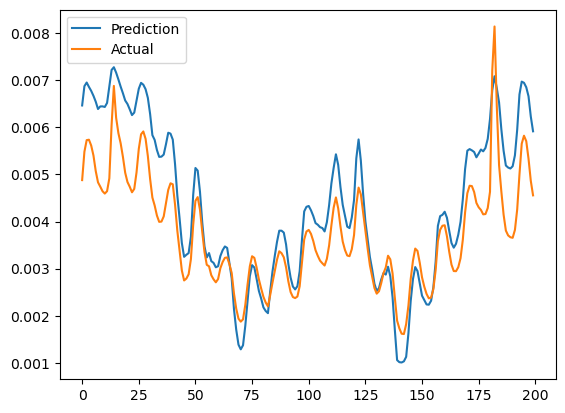

In [21]:
import matplotlib.pyplot as plt
s = 1000
e = s + 200
plt.plot(fy_prediction[0].detach()[s:e],label  = "Prediction")
plt.plot(t_out_fy.detach()[s:e],label  = "Actual")
plt.legend()

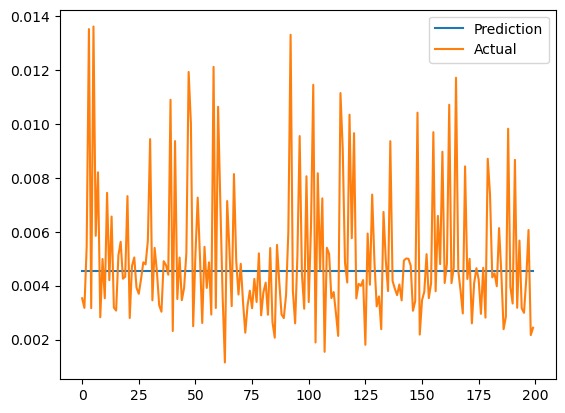

In [18]:
s = 0
e = s + 200
plt.plot(test_predictions[0].detach()[s:e],label  = "Prediction")
plt.plot(d_ft_out["test"][s:e],label  = "Actual")

plt.legend()

In [19]:
results[["Tr_l_mae","Te_l_mae","fy_l_mae","Te_l_mse","fy_l_mse","Train_time","Eval_time"]]

,Tr_l_mae,Te_l_mae,fy_l_mae,Te_l_mse,fy_l_mse,Train_time,Eval_time
1,0.001424,0.001403,0.0014,0.000004,0.000005,44.36493,0.021372


In [75]:
lr

0.0025

In [14]:
t_out_fy.shape

torch.Size([8736])

In [6]:
def get_random_hours_slicer(nb_available,nb_selected,min_offset = 1,sorted = True):
    assert(nb_available>=nb_selected*min_offset)
    idx_l_size = 0
    index_list = []
    counter = 0
    while idx_l_size < nb_selected:
        r = random.randint(0, nb_available)
        after = list(range(r,r+min_offset))
        before = list(range(r-min_offset+1,r+1))
        if set(index_list).isdisjoint(before) and set(index_list).isdisjoint(after):
            idx_l_size += 1
            index_list.append(r)
            counter = 0 
        counter += 1
        assert(counter <1e7)
    if sorted:
        return np.sort(index_list)
    else:
        return index_list


In [34]:
def get_random_days_slicer(hours_available,nb_selected,hours_in_day=24,sorted = True):
    assert(hours_available>=nb_selected*hours_in_day)

    index_list = []
    for i in range(nb_selected):
        r = random.randint(0, hours_available)
        i = hours_in_day * round(r/hours_in_day)

        while i in index_list: 
            r = random.randint(0, hours_available)
            i = hours_in_day * round(r/hours_in_day)
        this_index_list = [i+j for j in range(hours_in_day)]
        index_list.append(this_index_list)
    if sorted: 
        return np.sort((np.array(index_list)).flatten())
    else: 
        return np.array(index_list).flatten()

In [90]:
#Some initialising stuff
sc = "sc01"
period = "2030"
case = "3-bus"

folder = f"../Data/{case}_DC_fy"

all_executions = DataLoading.list_executions(folder=folder, per=period, sc=sc)
executions_start = 0
executions_end = len(all_executions)
executions = all_executions[executions_start:executions_end]
te_s = 0.3
val_s = 0.4
outp = "SystemCosts"

# exec_name = f"3-bus_AC_12w_dummy_{te_s}_v{val_s}_PF_LCOE_{executions_start}_{executions_end}"
exec_name = f"{case}_AC_12w_dummy_{te_s}_v{val_s}_PF_LCOE_{executions_start}_{executions_end}"
#exec_name = f"RTS24_AC_12w_dummy_{te_s}_v{val_s}_PF_LCOE_{executions_start}_{executions_end}"

folder_to_save = f"{exec_name}"

#Load inputs and outputs in dataframes
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, executions, period, sc, ["PowerFlow"],outp)
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)

# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, executions, te_s, val_s)

#Create dataloaders
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, executions)

#Create TensorDatasets
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float(), d_ft_inter['train'])
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float(), d_ft_inter['val'].float())

#Perform the actual loop that checks multiple hyperparams
i = 0
nbs_hidden = [(2, 0)]
dors = [0]
relu_outs = [False]
batch_sizes = [64]
learning_rates = [0.0025 * 4 ** i for i in range(-1, 0, 1)]
nbs_e = [128]  # ,8]
negative_penalisations = [0]
alphas = [0,]

beta = 1
MAEs = [True]
results = pd.DataFrame()

hp_sets = ((nb_h, dor, relu_out, bs, lr, nb_e, np, alpha,MAE) for nb_h in nbs_hidden for dor in dors for relu_out in
           relu_outs for bs in batch_sizes for lr in learning_rates for nb_e in nbs_e for np in
           negative_penalisations for alpha in alphas for MAE in MAEs)

inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

print(f"Number of hyperparameter combinations to be considered: {len(list(hp_sets))}, {len(nbs_e)} in the epochs dim")
hp_sets = ((nb_h, dor, relu_out, bs, lr, nb_e, np, alpha,MAE) for nb_h in nbs_hidden for dor in dors for relu_out in
           relu_outs for bs in batch_sizes for lr in learning_rates for nb_e in nbs_e for np in
           negative_penalisations for alpha in alphas for MAE in MAEs)
print("test")
counter = 0
for hp_set in hp_sets:
    counter+=1
    print(hp_set, "Counter:",counter)
    nb_hidden, dor, relu_out, bs, lr, nb_e, np, alpha,MAE = hp_set[0], hp_set[1], hp_set[2], hp_set[3], hp_set[4], hp_set[
        5], hp_set[6], hp_set[7],hp_set[8]

    # Create training and validation loaders based on batch size
    training_loader = DataLoader(train, batch_size=bs)
    validation_loader = DataLoader(validation, batch_size=bs)

    # Initialize loss functions
    loss_fn = NN_classes.create_custom_loss(alpha=alpha, beta=beta,MAE=MAE)
    loss_t_mse = torch.nn.MSELoss()
    loss_mae = torch.nn.L1Loss()

    # Create model based on hyperparameter set
    m = NN_classes.create_model(nb_hidden, d_ft_in['train'].shape[1], dropout_ratio=dor, relu_out=relu_out, inter=True,
                                inter_size=inter_size)
    # Create model name for saving and loading
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"
    # Create optimizer based on learning rate
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    # Train the actual model
    t_start_train = time.perf_counter()
    train_loss_1 = \
    training_methods.train_multiple_epochs(nb_e, m, training_loader, validation_loader, loss_fn, optimizer, m_name,
                                           folder_to_save, True)[0]
    t_stop_train = time.perf_counter()

    # In the following loop, we retreive the models from saved locations and calculate losses
    for mt in ["min_val", "all_epochs"]:
        t_start_eval = time.perf_counter()
        path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"

        # Retreive model state and set to evaluation mode
        m.load_state_dict(torch.load(path))
        m.eval()

        # Calculate losses
        test_predictions = m(d_ft_in["test"].float())
        test_loss = loss_fn(test_predictions[0].squeeze(), d_ft_out["test"], test_predictions[1].squeeze(),
                            d_ft_inter["test"])
        test_loss_t_mse = loss_t_mse(test_predictions[0].squeeze(), d_ft_out["test"])
        test_loss_mae = loss_mae(test_predictions[0].squeeze(), d_ft_out["test"])

        train_predictions = m(d_ft_in["train"].float())
        train_loss = loss_fn(train_predictions[0].squeeze(), d_ft_out["train"], train_predictions[1].squeeze(),
                             d_ft_inter["train"])
        train_loss_t_mse = loss_t_mse(train_predictions[0].squeeze(), d_ft_out["train"])
        train_loss_mae = loss_mae(train_predictions[0].squeeze(), d_ft_out["train"])

        validation_prediction = m(d_ft_in["val"].float())
        validation_loss = loss_fn(validation_prediction[0].squeeze(), d_ft_out["val"],
                                  validation_prediction[1].squeeze(), d_ft_inter["val"])
        validation_loss_t_mse = loss_t_mse(validation_prediction[0].squeeze(), d_ft_out["val"])
        validation_loss_mae = loss_mae(validation_prediction[0].squeeze(), d_ft_out["val"])

        t_stop_eval = time.perf_counter()

        # Calculate some calculation times
        t_train = t_stop_train - t_start_train
        t_eval = t_stop_eval - t_start_eval


        # Finally, save all desired values in a dataframe
        r = pd.DataFrame({"Model_type": [nb_hidden],
                          "Dor": dor,
                          "Relu_out": relu_out,
                          "Batch_size": bs,
                          "Lr": lr,
                          "Epochs": nb_e,
                          "Np": np,
                          "Min_val": mt,
                          "Tr_l": train_loss.item(),
                          "Te_l": test_loss.item(),
                          "V_l": validation_loss.item(),
                          "Tr_l_t_mse": train_loss_t_mse.item(),
                          "Te_l_t_mse": test_loss_t_mse.item(),
                          "V_l_t_mse": validation_loss_t_mse.item(),
                          "Tr_l_mae": train_loss_mae.item(),
                          "Te_l_mae": test_loss_mae.item(),
                          "V_l_mae": validation_loss_mae.item(),
                          "Tr_l_ret": train_loss_1.item(),
                          "Train_time": t_train,
                          "Eval_time": t_eval,
                          "alpha": alpha,
                          "beta": beta,
                          "MAE": MAE,
                          "Test size": te_s,
                          "Val size": val_s
                          }
                         , index=[i])
        i += 1
        results = pd.concat([results, r])

input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/3-bus_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_20/min_val/model_OE_(2, 0)h_128e_0.000625lr_0dor_0np_Falsero_64bs_0ill_TrueMAE.pth'

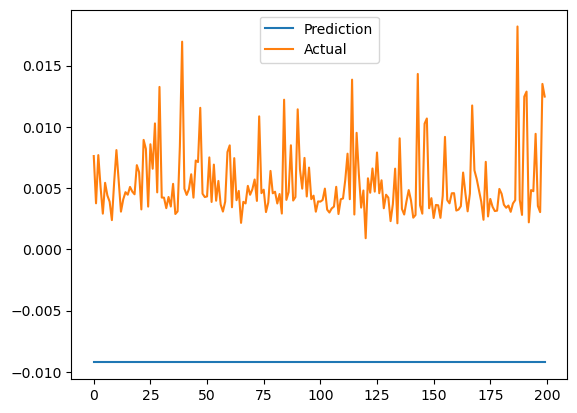

In [91]:
s = 0
e = s + 200
plt.plot(test_predictions[0].detach()[s:e],label  = "Prediction")
plt.plot(d_ft_out["test"][s:e],label  = "Actual")
plt.legend()